<p style="background-color:#e24b32;font-family:newtimeroman;color:#e4e4e5;font-size:150%;text-align:center;border-radius:10px 10px;">Ship Classication Using Transfer Learning<p>

Problem Statement : https://unstop.com/hackathon/lt-edutech-hackathon-at-shaastra-iitm-shaastra-2023-indian-institute-of-technology-iit-madras-579093  
Dataset : https://cutt.ly/PS_3_dataset


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score,classification_report

import os
import glob
import cv2

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.xception import preprocess_input,Xception

import warnings
warnings.filterwarnings("ignore")

# strategy = tf.distribute.MirroredStrategy()
# print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

FILE_DIR='/kaggle/input/game-of-deep-learning-ship-datasets/train/images'

In [13]:
submission=pd.read_csv('/kaggle/input/game-of-deep-learning-ship-datasets/sample_submission_ns2btKE.csv')
test=pd.read_csv('/kaggle/input/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv')
train=pd.read_csv('/kaggle/input/game-of-deep-learning-ship-datasets/train/train.csv')

For Reference : `{0: 'Cargo', 1:'Military', 2:'Carrier', 3:'Cruise', 4:'Tankers'}`

In [14]:
d={}

for i in glob.glob(FILE_DIR+'/*.jpg'):
    img=cv2.imread(i)
    resulting_img = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
    final_image=tf.keras.applications.xception.preprocess_input(resulting_img)
    d[os.path.basename(i)]=final_image

In [15]:
train_img_list=list(train.image)
test_img_list=list(test.image)

In [16]:
train_dic={k: d[k] for k in train_img_list} 
test_dic={k: d[k] for k in test_img_list} 

In [17]:
model_inputs=np.array(list(train_dic.values()))

In [18]:
train_labels=np.array(list(train.category))-1

In [19]:
X_train, X_test, y_train, y_test = train_test_split(model_inputs,train_labels, test_size=0.1, random_state=42)

In [20]:
X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [21]:
base_model=Xception(weights="imagenet",include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(5,activation='softmax')(avg)
model = tf.keras.Model(inputs=base_model.input,outputs=output)

In [22]:
for layer in base_model.layers:
    layer.trainable=False
# with tpu_strategy.scope():
optimizer = tf.keras.optimizers.SGD(lr=0.2,momentum=0.9,decay=0.01)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])


# with strategy.scope():
history = model.fit(x=model_inputs,y=train_labels,epochs=5,validation_data=(X_val,y_val))

2023-01-19 17:03:02.281007: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1229193216 exceeds 10% of free system memory.
2023-01-19 17:03:03.617029: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1229193216 exceeds 10% of free system memory.


Epoch 1/5
196/196 [==============================] - 14s 60ms/step - loss: 8.6567 - accuracy: 0.6607 - val_loss: 4.6751 - val_accuracy: 0.7265
Epoch 2/5
196/196 [==============================] - 11s 55ms/step - loss: 2.7330 - accuracy: 0.7759 - val_loss: 1.9280 - val_accuracy: 0.7922
Epoch 3/5
196/196 [==============================] - 11s 54ms/step - loss: 2.0486 - accuracy: 0.7922 - val_loss: 1.2573 - val_accuracy: 0.8250
Epoch 4/5
196/196 [==============================] - 10s 53ms/step - loss: 1.4432 - accuracy: 0.8165 - val_loss: 1.1887 - val_accuracy: 0.8206
Epoch 5/5
196/196 [==============================] - 10s 52ms/step - loss: 0.9272 - accuracy: 0.8436 - val_loss: 0.7553 - val_accuracy: 0.8686


In [23]:
for layer in base_model.layers:
    layer.trainable=True
# with tpu_strategy.scope():
optimizer = tf.keras.optimizers.SGD(lr=0.2,momentum=0.9,decay=0.01)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])

history = model.fit(x=model_inputs,y=train_labels,epochs=25,validation_data=(X_val,y_val))

2023-01-19 17:04:28.762598: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1229193216 exceeds 10% of free system memory.


Epoch 1/25
196/196 [==============================] - 47s 211ms/step - loss: 1.5621 - accuracy: 0.3386 - val_loss: 15.9656 - val_accuracy: 0.3002
Epoch 2/25
196/196 [==============================] - 39s 197ms/step - loss: 1.5223 - accuracy: 0.3629 - val_loss: 2.2668 - val_accuracy: 0.3321
Epoch 3/25
196/196 [==============================] - 39s 197ms/step - loss: 1.4990 - accuracy: 0.3773 - val_loss: 1.5531 - val_accuracy: 0.3490
Epoch 4/25
196/196 [==============================] - 39s 197ms/step - loss: 1.4152 - accuracy: 0.4123 - val_loss: 1.7354 - val_accuracy: 0.4139
Epoch 5/25
196/196 [==============================] - 39s 198ms/step - loss: 1.3275 - accuracy: 0.4338 - val_loss: 1.3848 - val_accuracy: 0.4014
Epoch 6/25
196/196 [==============================] - 39s 198ms/step - loss: 1.1902 - accuracy: 0.4725 - val_loss: 1.3020 - val_accuracy: 0.4547
Epoch 7/25
196/196 [==============================] - 39s 198ms/step - loss: 1.0807 - accuracy: 0.5198 - val_loss: 0.9989 - val_a

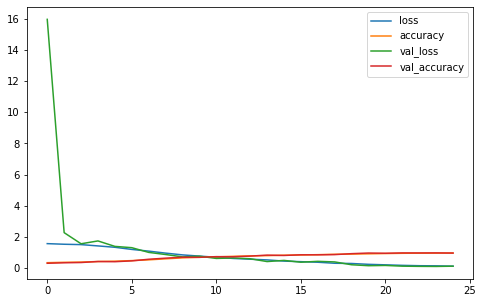

In [24]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.show()

In [25]:
y_pred_ = model.predict(X_test)
y_pred = np.argmax(y_pred_,axis=1)

In [26]:
print(f"Classifiction Report :\n {classification_report(y_test,y_pred)}")

Classifiction Report :
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       201
           1       1.00      0.95      0.97       112
           2       0.85      1.00      0.92        95
           3       0.96      0.99      0.98        82
           4       0.98      0.88      0.92       136

    accuracy                           0.96       626
   macro avg       0.95      0.96      0.95       626
weighted avg       0.96      0.96      0.96       626



<p style="background-color:#e24b32;font-family:newtimeroman;color:#e4e4e5;font-size:150%;text-align:center;border-radius:10px 10px;">Judging Metric : Kappa Score<p> 

In [27]:
kappa_scr=cohen_kappa_score(y_pred,y_test)
print(f"Kappa Score : {kappa_scr}")

Kappa Score : 0.9425842335938575


### Predicting Values for given test dataset

In [17]:
test_model_inputs=np.array(list(test_dic.values()))

In [18]:
output_labels = model.predict(test_model_inputs)

2023-01-19 14:53:08.596239: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 526909440 exceeds 10% of free system memory.


In [19]:
output_labels_ind = np.argmax(output_labels,axis=1)+1

In [20]:
np.bincount(output_labels_ind)

array([   0, 2651,   29])

In [21]:
submission['category']=output_labels_ind

In [22]:
submission.to_csv('submission_v1.csv',index=False)

<p style="background-color:#e24b32;font-family:newtimeroman;color:#e4e4e5;font-size:150%;text-align:center;border-radius:10px 10px;">Optimal Training dataset size<p> 

In [23]:
split_size_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
kappa_score=[]

In [ ]:
for i in split_size_list:    
    X_train, X_test, y_train, y_test = train_test_split(model_inputs,train_labels, test_size=i, random_state=42)
    X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    base_model=Xception(weights="imagenet",include_top=False)
    avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = tf.keras.layers.Dense(5,activation='softmax')(avg)
    model = tf.keras.Model(inputs=base_model.input,outputs=output)
    for layer in base_model.layers:
        layer.trainable=False
    # with tpu_strategy.scope():
    optimizer = tf.keras.optimizers.SGD(lr=0.2,momentum=0.9,decay=0.01)
    model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])


    # with strategy.scope():
    history = model.fit(x=model_inputs,y=train_labels,epochs=5,validation_data=(X_val,y_val))

    for layer in base_model.layers:
        layer.trainable=True
    # with tpu_strategy.scope():
    optimizer = tf.keras.optimizers.SGD(lr=0.2,momentum=0.9,decay=0.01)
    model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])

    history = model.fit(x=model_inputs,y=train_labels,epochs=25,validation_data=(X_val,y_val))

    y_pred_ = model.predict(X_test)
    y_pred = np.argmax(y_pred_,axis=1)

    kappa_score.append(cohen_kappa_score(y_pred,y_test))

Epoch 1/5
196/196 [==============================] - 14s 57ms/step - loss: 12.9296 - accuracy: 0.6513 - val_loss: 4.3956 - val_accuracy: 0.7620
Epoch 2/5
196/196 [==============================] - 10s 51ms/step - loss: 4.0280 - accuracy: 0.7577 - val_loss: 2.1921 - val_accuracy: 0.8171
Epoch 3/5
196/196 [==============================] - 10s 52ms/step - loss: 2.0381 - accuracy: 0.8090 - val_loss: 1.5355 - val_accuracy: 0.8215
Epoch 4/5
196/196 [==============================] - 10s 52ms/step - loss: 1.4497 - accuracy: 0.8337 - val_loss: 0.9966 - val_accuracy: 0.8597
Epoch 5/5
196/196 [==============================] - 10s 51ms/step - loss: 1.1811 - accuracy: 0.8343 - val_loss: 0.9709 - val_accuracy: 0.8588
Epoch 1/25
196/196 [==============================] - 43s 201ms/step - loss: 1.5751 - accuracy: 0.3289 - val_loss: 1.5492 - val_accuracy: 0.3410
Epoch 2/25
196/196 [==============================] - 37s 188ms/step - loss: 1.5523 - accuracy: 0.3391 - val_loss: 1.5511 - val_accuracy: 0

In [ ]:
plt.plot(np.array(split_size_list)*100,np.array(kappa_score))
plt.xlabel("Training Data %")
plt.ylabel("Metric - Kappa Score")
plt.show()

- Best percentage is when the model attain highest kappa score